# First Neural Network

In [8]:
import sys
import os
from dotenv import load_dotenv
load_dotenv()
directory_path = os.path.expanduser(os.environ.get('PACKAGE_PATH'))
sys.path.append(directory_path)
from frugal.data.preprocessor import preprocess_text

In [9]:
print(directory_path)

/Users/lodus/code/jscordel/frugal/


In [10]:
#pip install pyarrow

In [11]:
#pip install fsspec


In [12]:
#pip install huggingface_hub

In [13]:
#pip install tensorflow

In [14]:
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/QuotaClimat/frugalaichallenge-text-train/" + splits["train"])

/Users/lodus/.pyenv/versions/3.10.6/envs/frugal/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
X = df[["quote"]]
y = df["label"]

In [16]:
X["quote"]

0       Interesting to note that Oklahoma minimum temp...
1       REPORT ON GEO ENGINEERING A.k.a. man-made FAKE...
2       To realize, yes, climate change is a real prob...
3       The fluctuations in the carbon dioxide concent...
4       I know the comments that were made after that ...
                              ...                        
4867    The morally superior choice is for people to b...
4868    The climate is changing. No one is denying cli...
4869    It will be up to 15 years before it is possibl...
4870    Global warming is real, but a problem, not the...
4871    Can any of the areas of the science now be con...
Name: quote, Length: 4872, dtype: object

In [17]:
import numpy as np
np.unique(y)

array(['0_not_relevant', '1_not_happening', '2_not_human', '3_not_bad',
       '4_solutions_harmful_unnecessary', '5_science_unreliable',
       '6_proponents_biased', '7_fossil_fuels_needed'], dtype=object)

In [ ]:
y_encoded = y.map({'0_not_relevant':0,
                   '1_not_happening': 1,
                   '2_not_human':2,
                   '3_not_bad':3,
                   '4_solutions_harmful_unnecessary':4,
                   '5_science_unreliable':5,
                   '6_proponents_biased':6,
                   '7_fossil_fuels_needed':7})

y_encoded = np.array(y_encoded)

In [19]:
y_encoded

array([0, 6, 3, ..., 0, 4, 5])

In [20]:
X_preproc = X['quote'].apply(preprocess_text)
X_preproc

0       [interesting, to, note, that, oklahoma, minimu...
1       [report, on, geo, engineering, aka, manmade, f...
2       [to, realize, yes, climate, change, is, a, rea...
3       [the, fluctuation, in, the, carbon, dioxide, c...
4       [i, know, the, comment, that, were, made, afte...
                              ...                        
4867    [the, morally, superior, choice, is, for, peop...
4868    [the, climate, is, changing, no, one, is, deny...
4869    [it, will, be, up, to, year, before, it, is, p...
4870    [global, warming, is, real, but, a, problem, n...
4871    [can, any, of, the, area, of, the, science, no...
Name: quote, Length: 4872, dtype: object

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer

# This initializes a Keras utilities that does all the tokenization for you
tokenizer = Tokenizer()

# The tokenization learns a dictionary that maps a token (integer) to each word
# It can be done only on the train set - we are not supposed to know the test set!
# This tokenization also lowercases your words, apply some filters, and so on - you can check the doc if you want
tokenizer.fit_on_texts(X_preproc)

# We apply the tokenization to the train and test set
X_train_token = tokenizer.texts_to_sequences(X_preproc)

In [22]:
vocab_size = len(tokenizer.word_index)
vocab_size

13701

In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [24]:
X_train_pad = pad_sequences(X_train_token, dtype='float32', padding='pre')

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense


embedding_dim = 20


model = Sequential()


model.add(Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, mask_zero=True))


model.add(LSTM(10))

model.add(Dense(64, activation='relu'))


model.add(Dense(8, activation='softmax'))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
y_encoded.shape

(4872,)

In [28]:
X_train_pad.shape

(4872, 838)

In [29]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Fit the model
history = model.fit(
    X_train_pad,  # Your training data
    y_encoded,  # Your training labels
    epochs=20,
    batch_size=32,  # Choose an appropriate batch size
    validation_split=0.2,  # Use 20% of the data for validation
    callbacks=[early_stopping]
)

Epoch 1/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.2648 - loss: 2.0174 - val_accuracy: 0.3549 - val_loss: 1.7652
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - accuracy: 0.3558 - loss: 1.6844 - val_accuracy: 0.3518 - val_loss: 1.6424
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.3668 - loss: 1.5082 - val_accuracy: 0.3610 - val_loss: 1.6269
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 0.4374 - loss: 1.3109 - val_accuracy: 0.3836 - val_loss: 1.6670
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.5677 - loss: 1.0813 - val_accuracy: 0.3938 - val_loss: 1.6938
Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.7020 - loss: 0.8239 - val_accuracy: 0.3990 - val_loss: 1.8845
Epoch 7/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.7894 - loss: 0.6317 - val_accuracy: 0.4195 - val_loss: 2.0606


# Trying to prevent overfitting

In [49]:
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/QuotaClimat/frugalaichallenge-text-train/" + splits["train"])

In [50]:
X = df[["quote"]]
y = df["label"]

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [53]:
y_train_encoded = y_train.map({'0_not_relevant':0,
                   '1_not_happening': 1,
                   '2_not_human':2,
                   '3_not_bad':3,
                   '4_solutions_harmful_unnecessary':4,
                   '5_science_unreliable':5,
                   '6_proponents_biased':6,
                   '7_fossil_fuels_needed':7})

y_train_encoded = np.array(y_train_encoded)

y_test_encoded = y_test.map({'0_not_relevant':0,
                   '1_not_happening': 1,
                   '2_not_human':2,
                   '3_not_bad':3,
                   '4_solutions_harmful_unnecessary':4,
                   '5_science_unreliable':5,
                   '6_proponents_biased':6,
                   '7_fossil_fuels_needed':7})

y_test_encoded = np.array(y_test_encoded)

In [54]:
X_train_preproc = X_train['quote'].apply(preprocess_text)
X_train_preproc

X_test_preproc = X_test['quote'].apply(preprocess_text)
X_test_preproc

1165    [wart, and, all, no, country, ha, ever, done, ...
1979    [there, ’, s, much, we, know, and, can, agree,...
917     [donorstrust, where, i, work, serf, donor, ded...
4092    [how, dare, you, smear, me, and, label, me, fo...
1126    [thats, why, the, left, went, from, global, wa...
                              ...                        
541     [the, president, sat, on, the, keystone, pipel...
2769    [make, no, mistake, about, it, global, warming...
4784    [reality, check, winter, of, coldest, winter, ...
3319    [for, now, energy, is, carbon, based, because,...
602     [you, know, i, think, that, solar, wind, all, ...
Name: quote, Length: 1462, dtype: object

In [55]:
from tensorflow.keras.preprocessing.text import Tokenizer

# This initializes a Keras utilities that does all the tokenization for you
tokenizer = Tokenizer()

# The tokenization learns a dictionary that maps a token (integer) to each word
# It can be done only on the train set - we are not supposed to know the test set!
# This tokenization also lowercases your words, apply some filters, and so on - you can check the doc if you want
tokenizer.fit_on_texts(X_preproc)

# We apply the tokenization to the train and test set
X_train_token = tokenizer.texts_to_sequences(X_train_preproc)
X_test_token = tokenizer.texts_to_sequences(X_test_preproc)

In [56]:
vocab_size = len(tokenizer.word_index)
vocab_size

13701

In [57]:
X_train_pad = pad_sequences(X_train_token, dtype='float32', padding='pre')
X_test_pad = pad_sequences(X_test_token, dtype='float32', padding='pre')

In [32]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Fit the model
history = model.fit(
    X_train,  # Your training data
    y_train,  # Your training labels
    epochs=20,
    batch_size=32,  # Choose an appropriate batch size
    validation_split=0.2,  # Use 20% of the data for validation
    callbacks=[early_stopping]
)

Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 0.4074 - loss: 1.3935 - val_accuracy: 0.4047 - val_loss: 1.3553
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.4567 - loss: 1.2671 - val_accuracy: 0.4413 - val_loss: 1.3044
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.5510 - loss: 1.1210 - val_accuracy: 0.4780 - val_loss: 1.2816
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.6399 - loss: 0.9568 - val_accuracy: 0.4897 - val_loss: 1.2648
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 0.7235 - loss: 0.7704 - val_accuracy: 0.5205 - val_loss: 1.2681
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 0.7918 - loss: 0.6264 - val_accuracy: 0.5059 - val_loss: 1.3650
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - accuracy: 0.8447 - loss: 0.4729 - val_accuracy: 0.5147 - val_loss: 1.4890
Epoch 8/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 0.8832 - loss: 0.3900 - val_accu

In [33]:
model.evaluate(X_test,y_test)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5099 - loss: 1.3123


[1.3195680379867554, 0.5075239539146423]

In [36]:
# DATA VISUALIZATION
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))

    # --- LOSS ---

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])

    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')

    ax[0].set_ylim((0,3))

    ax[0].legend(['Train', 'Test'], loc='best')

    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- ACCURACY

    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])

    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')

    ax[1].legend(['Train', 'Test'], loc='best')

    ax[1].set_ylim((0,1))

    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

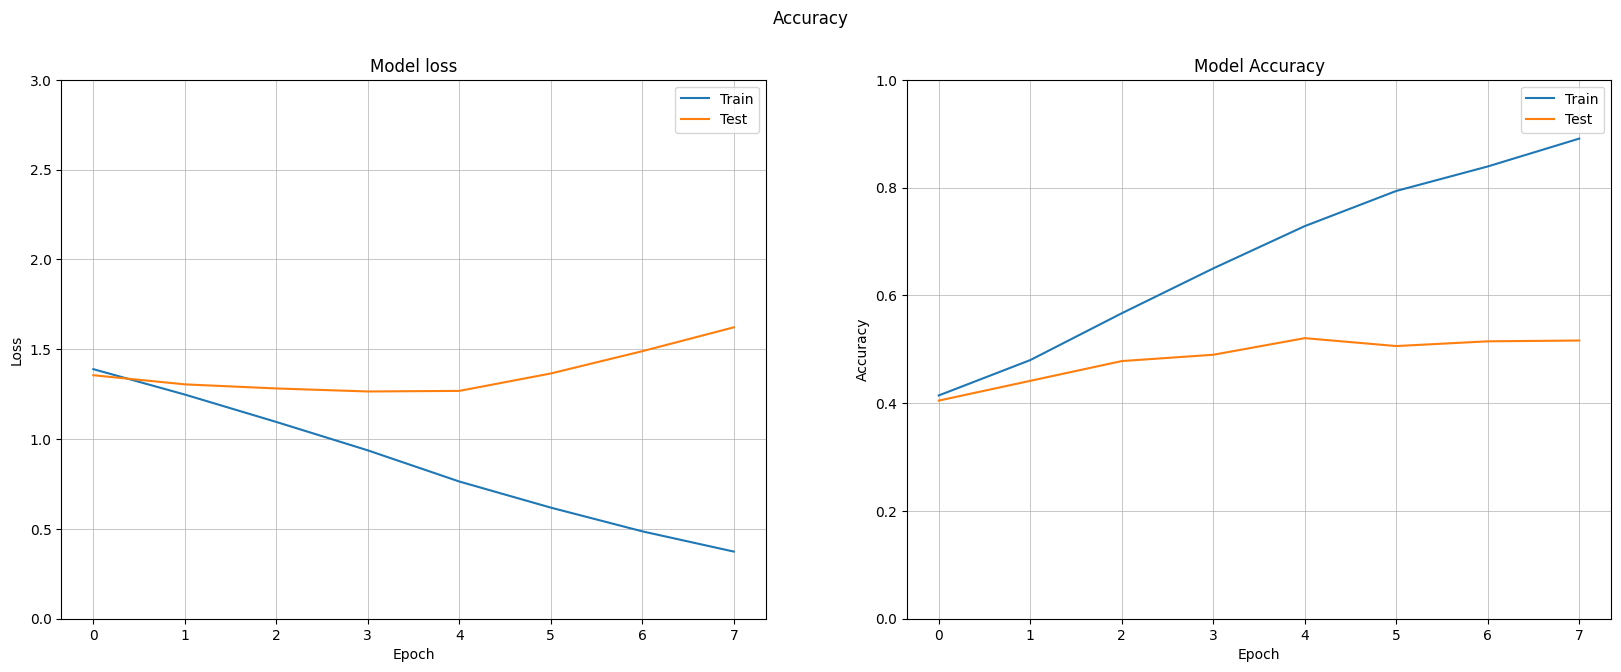

In [38]:
plot_loss_accuracy(history, title='Accuracy')

In [40]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = model.fit(
    X_train,  # Your training data
    y_train,  # Your training labels
    epochs=20,
    batch_size=32,  # Choose an appropriate batch size
    validation_split=0.2,  # Use 20% of the data for validation
    callbacks=[early_stopping]
)

Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 0.7472 - loss: 0.7223 - val_accuracy: 0.5088 - val_loss: 1.3126
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 0.7966 - loss: 0.6003 - val_accuracy: 0.5073 - val_loss: 1.3992
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 0.8509 - loss: 0.4690 - val_accuracy: 0.5191 - val_loss: 1.4686
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 0.9048 - loss: 0.3599 - val_accuracy: 0.5249 - val_loss: 1.6713
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 0.9339 - loss: 0.2732 - val_accuracy: 0.5220 - val_loss: 1.8509
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 0.9270 - loss: 0.2717 - val_accuracy: 0.5000 - val_loss: 1.9830
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.9574 - loss: 0.1810 - val_accuracy: 0.5015 - val_loss: 2.2529
Epoch 8/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 0.9646 - loss: 0.1469 - val_accu

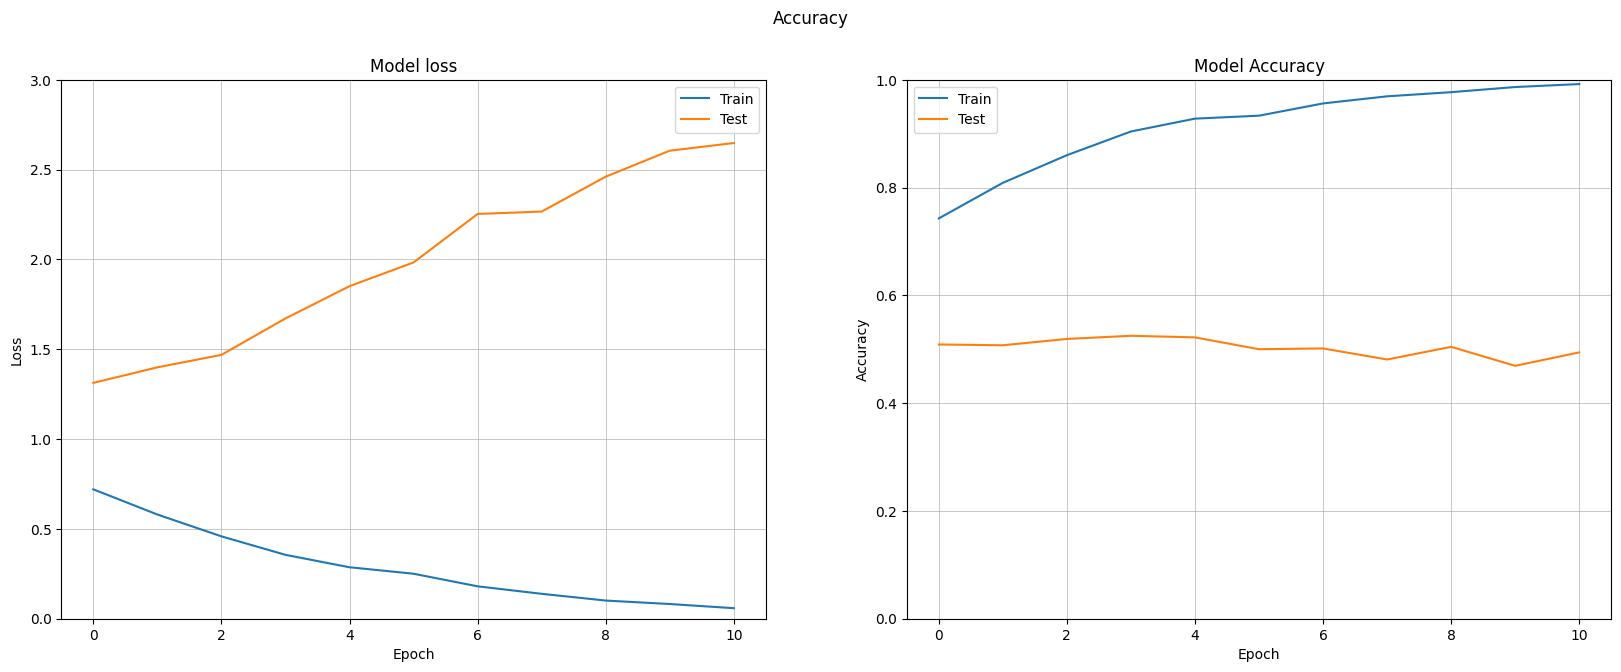

In [41]:
plot_loss_accuracy(history, title='Accuracy')

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = model.fit(
    X_train,  # Your training data
    y_train,  # Your training labels
    epochs=20,
    batch_size=32,  # Choose an appropriate batch size
    validation_split=0.2,  # Use 20% of the data for validation
    callbacks=[early_stopping]
)

CPU times: user 10min 10s, sys: 18.9 s, total: 10min 29s
Wall time: 10min 15s


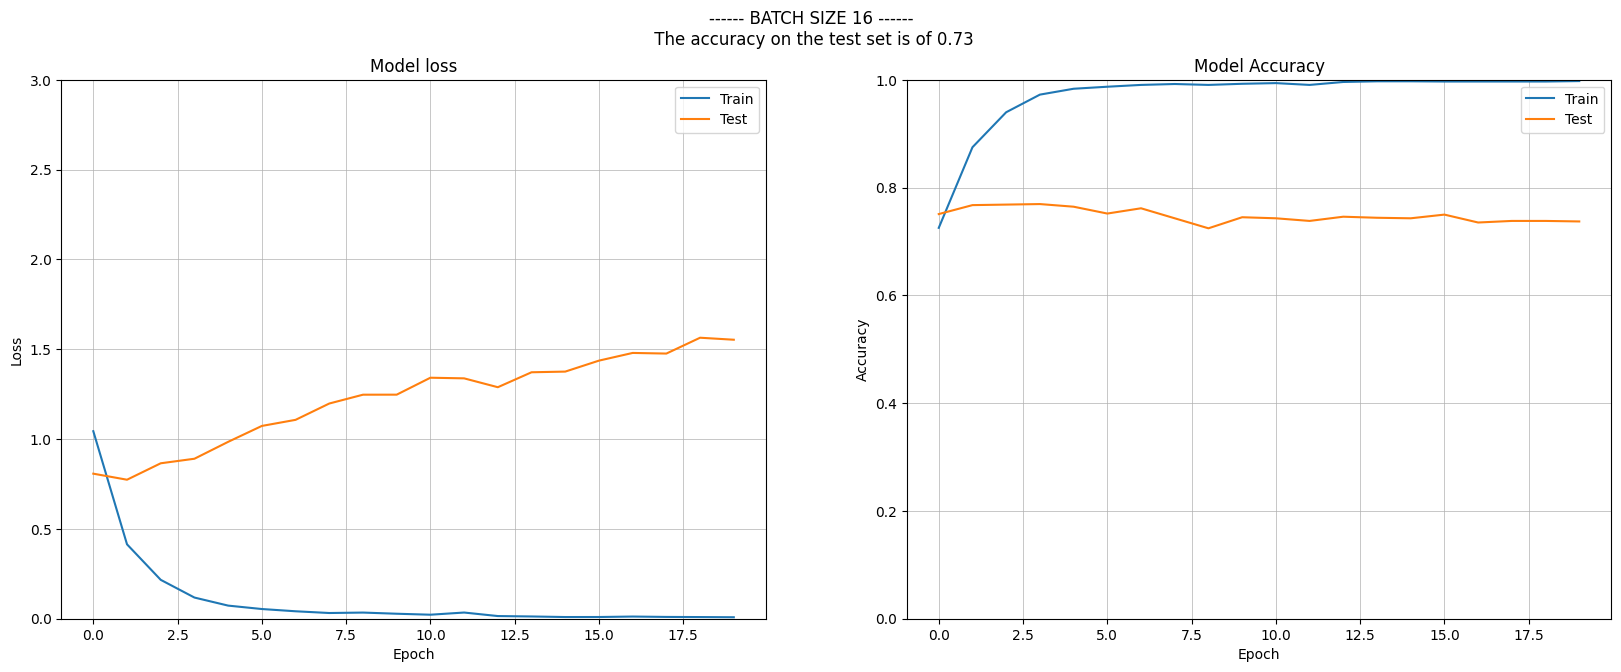

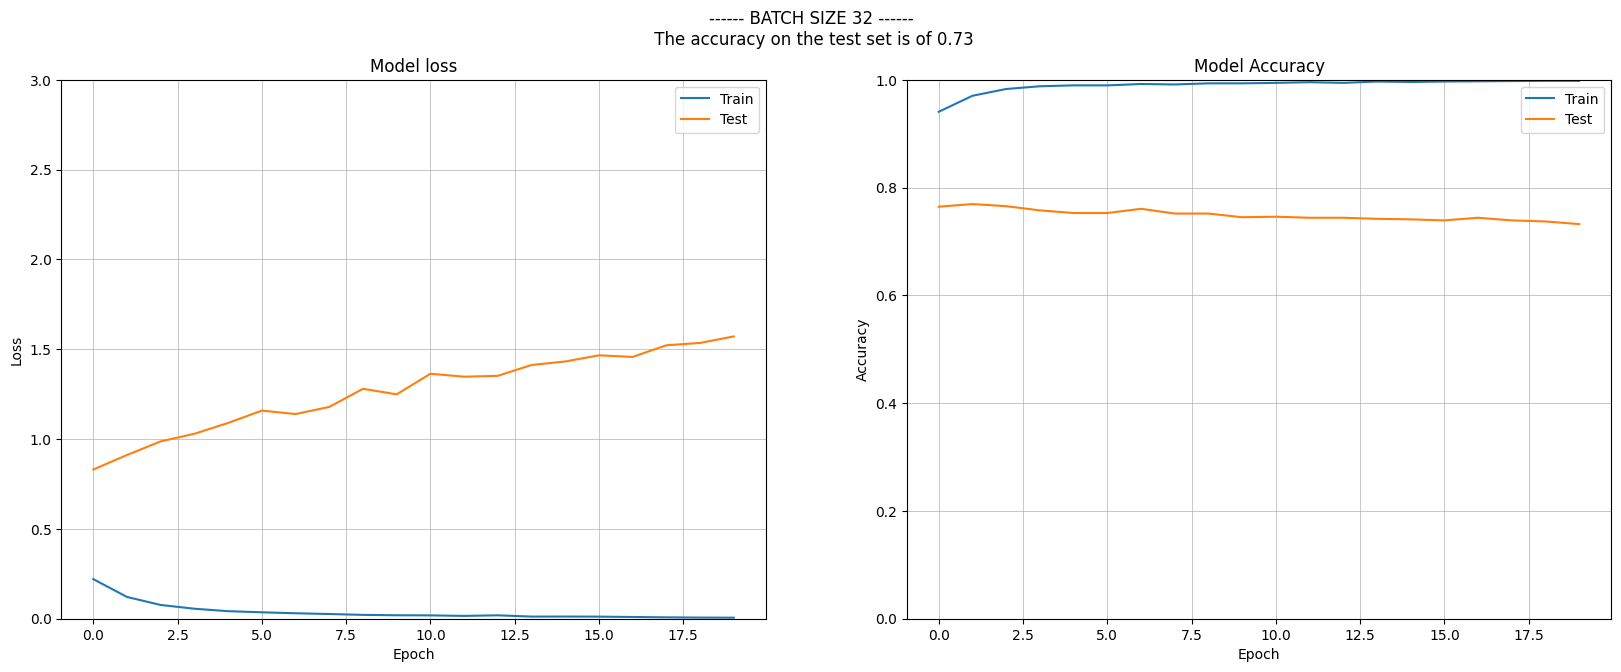

In [60]:
%%time
# RUN THIS CELL
es = EarlyStopping(patience=20, restore_best_weights=True)

for batch_size in [16, 32]:

    history = model.fit(
        X_train_pad,
        y_train_encoded,
        validation_split = 0.3,
        epochs = 20,
        batch_size = batch_size,
        verbose = 0,
        callbacks = [es]
    )

    results = model.evaluate(X_test_pad,y_test_encoded, verbose=0)
    plot_loss_accuracy(history, title=f'------ BATCH SIZE {batch_size} ------\n The accuracy on the test set is of {results[1]:.2f}')